In [1]:
import os
import pandas as pd
import numpy as np

# Root path on your desktop
base_path = r"C:\Users\amedh\OneDrive\Desktop\Amedh\bearing"
target_tests = ["2nd_test", "3rd_test"]

def process_raw_files(folder_name):
    extracted_data = []
    folder_path = os.path.join(base_path, folder_name)
    
    for root, dirs, files in os.walk(folder_path):
        for file in sorted(files):
            if file.startswith('20'): 
                path = os.path.join(root, file)
                # Load the 20,480 points (4 columns for Test 2 & 3)
                df_temp = pd.read_csv(path, sep='\t', header=None)
                
                # Feature Extraction (RMS and Kurtosis)
                stats = {'timestamp': file, 'source': folder_name}
                for i in range(4):
                    signal = df_temp.iloc[:, i]
                    stats[f'B{i+1}_RMS'] = np.sqrt(np.mean(signal**2))
                    stats[f'B{i+1}_Kurt'] = signal.kurtosis()
                extracted_data.append(stats)
                
    return pd.DataFrame(extracted_data)

# Run the ingestion
df = pd.concat([process_raw_files(t) for t in target_tests], ignore_index=True)

In [2]:
df.head()

,timestamp,source,B1_RMS,B1_Kurt,B2_RMS,B2_Kurt,B3_RMS,B3_Kurt,B4_RMS,B4_Kurt
0,2004.02.12.10.32.39,2nd_test,0.074179,0.629209,0.090944,0.507217,0.109404,3.214152,0.054103,0.066268
1,2004.02.12.10.42.39,2nd_test,0.075382,0.648742,0.093419,0.253369,0.109817,1.395884,0.056101,0.107859
2,2004.02.12.10.52.39,2nd_test,0.076230,0.513894,0.093718,0.311158,0.109861,2.640886,0.056145,0.257592
3,2004.02.12.11.02.39,2nd_test,0.078724,1.158529,0.092947,0.235691,0.110667,2.683727,0.056807,0.806680
4,2004.02.12.11.12.39,2nd_test,0.078474,0.603617,0.095348,0.226657,0.107506,1.579073,0.056841,0.139281


In [3]:
# Convert to datetime and calculate RUL in minutes
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y.%m.%d.%H.%M.%S')
df['RUL'] = df.groupby('source')['timestamp'].transform(lambda x: (x.max() - x).dt.total_seconds() / 60)

# Local Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat_cols = [c for c in df.columns if 'B' in c]

# Scale each test independently to handle sensor variations
for s in df['source'].unique():
    mask = df['source'] == s
    df.loc[mask, feat_cols] = scaler.fit_transform(df.loc[mask, feat_cols])

In [4]:
def create_masked_data(df, window_size=30, mask_rate=0.15):
    X, X_masked, Y_rul = [], [], []
    for s in df['source'].unique():
        group = df[df['source'] == s][feat_cols].values
        ruls = df[df['source'] == s]['RUL'].values
        
        for i in range(len(group) - window_size):
            window = group[i : i + window_size].copy()
            # Task 1: Store the original window as the reconstruction target
            X.append(window)
            
            # Task 2: Create a masked version for Self-Supervision
            masked_window = window.copy()
            mask = np.random.rand(*masked_window.shape) < mask_rate
            masked_window[mask] = 0 # "Hide" 15% of the data
            X_masked.append(masked_window)
            
            # Task 3: Store the RUL for the regression head
            Y_rul.append(ruls[i + window_size])
            
    return np.array(X), np.array(X_masked), np.array(Y_rul)

X_orig, X_train_masked, Y_train_rul = create_masked_data(df)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1. POSITIONAL ENCODING LAYER
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def get_angles(self, pos, i, d_model):
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 2. TRANSFORMER ENCODER BLOCK
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward (FFN)
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# 3. BUILD THE MULTI-TASK MODEL
def build_multi_task_transformer(window_size, num_features):
    inputs = keras.Input(shape=(window_size, num_features))
    
    # Embedding + Positional Encoding
    x = layers.Dense(64)(inputs)
    x = PositionalEncoding(window_size, 64)(x)
    
    # Transformer Layers (Stack of 2 blocks)
    for _ in range(2):
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
    
    # TASK 1: Reconstruction Head (Self-Supervised/Anomaly)
    recon_output = layers.Dense(num_features, name="recon")(x)
    
    # TASK 2: RUL Prediction Head (Regression)
    x_pooled = layers.GlobalAveragePooling1D()(x)
    x_pooled = layers.Dense(32, activation="relu")(x_pooled)
    rul_output = layers.Dense(1, name="rul")(x_pooled)
    
    model = keras.Model(inputs=inputs, outputs=[recon_output, rul_output])
    return model

# 4. INSTANTIATE AND COMPILE
model = build_multi_task_transformer(window_size=30, num_features=8)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={'recon': 'mse', 'rul': 'mae'},
    loss_weights={'recon': 0.5, 'rul': 0.5}
)

model.summary()

C:\Users\amedh\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 64)    │        576 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 30, 64)    │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 64)    │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 64)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 64)    │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 64)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 64)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 30, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 169,609 (662.54 KB)

 Trainable params: 169,609 (662.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# TRAINING THE DUAL-TASK TRANSFORMER
history = model.fit(
    x=X_train_masked,          
    y={
        'recon': X_orig,       
        'rul': Y_train_rul     
    },
    epochs=100,                
    batch_size=64,             
    validation_split=0.2,      
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 8388.6904 - recon_loss: 1314.2438 - rul_loss: 15436.9355 - val_loss: 16112.4912 - val_recon_loss: 4.1318 - val_rul_loss: 32042.3418
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 5529.3066 - recon_loss: 134.9446 - rul_loss: 10924.0938 - val_loss: 15542.0410 - val_recon_loss: 1.6535 - val_rul_loss: 30788.6934
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 5405.2681 - recon_loss: 58.5604 - rul_loss: 10757.4395 - val_loss: 16595.6680 - val_recon_loss: 1.6030 - val_rul_loss: 33039.0938
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 5385.5249 - recon_loss: 43.2299 - rul_loss: 10727.2627 - val_loss: 15220.9053 - val_recon_loss: 1.4595 - val_rul_loss: 30169.9785
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 5374.1167 - recon_loss: 35.3085 - rul_loss: 10709.6748 - val_loss: 15298.6592 - val_recon_loss: 0.9426 - val_rul_loss: 30361.7148
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


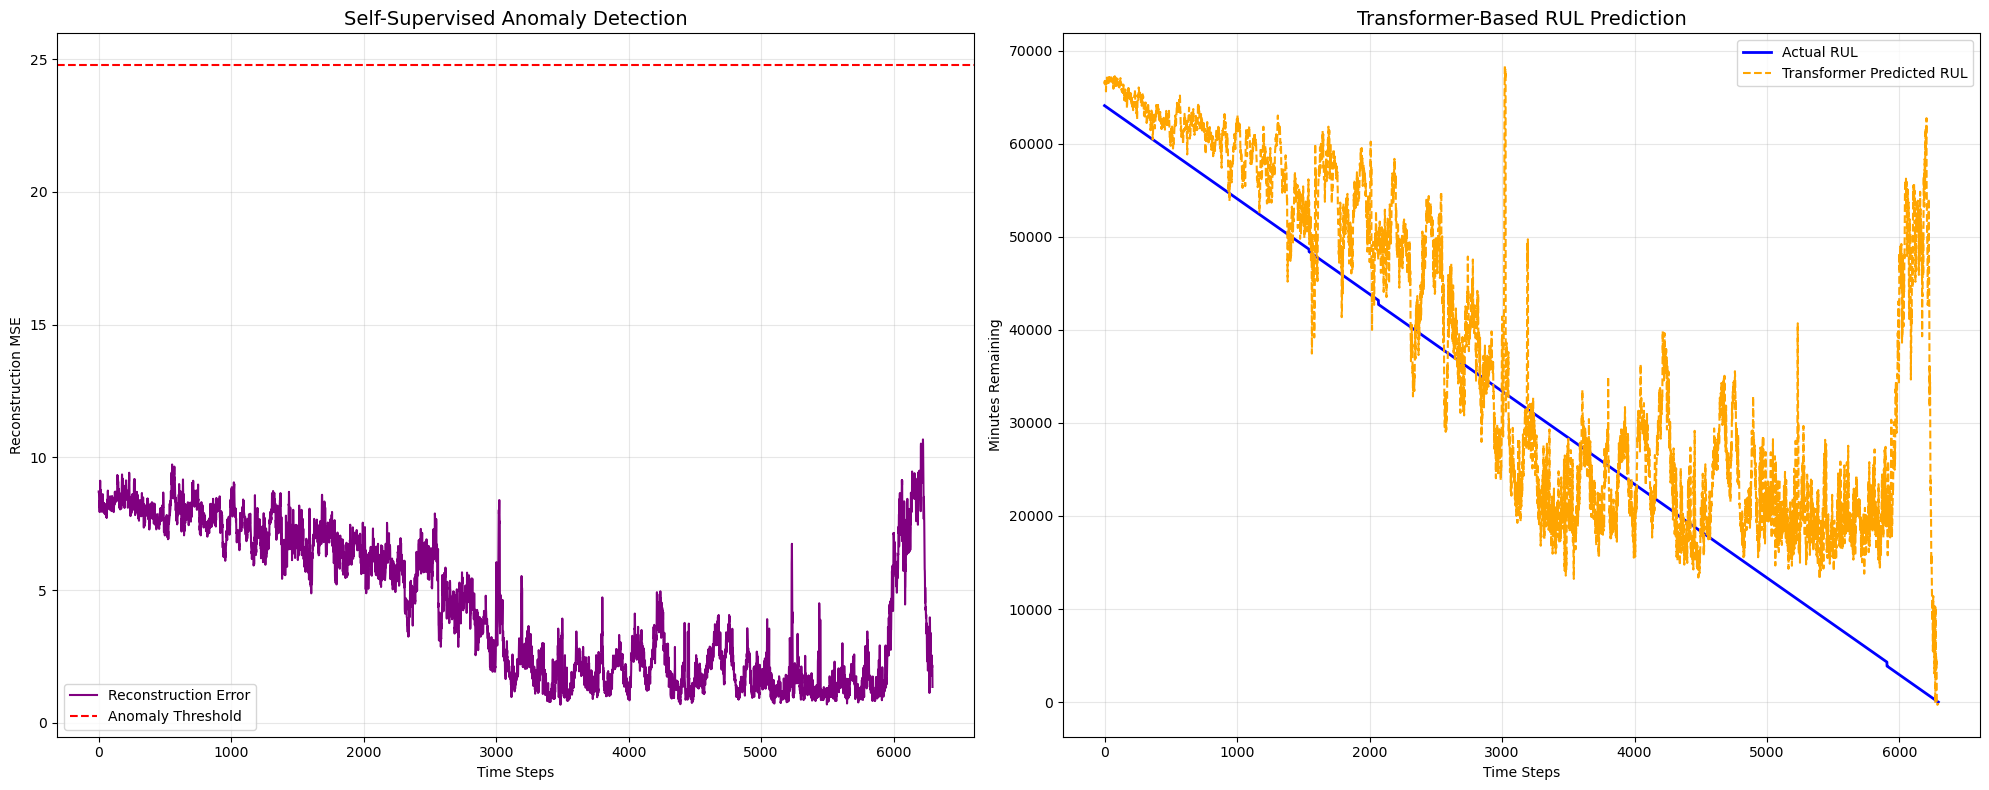

In [10]:
# 1. SPLIT THE DATA
test2_count = len(df[df['source'] == '2nd_test']) - 30

X_train = X_orig[:test2_count]
X_test = X_orig[test2_count:]

y_train = Y_train_rul[:test2_count]
y_test = Y_train_rul[test2_count:]

# 2. RUN THE PREDICTIONS
recon_preds, rul_preds = model.predict(X_test)

import matplotlib.pyplot as plt
import numpy as np

# 1. GET MODEL PREDICTIONS
recon_preds, rul_preds = model.predict(X_test)

# 2. CALCULATE ANOMALY SCORE (Reconstruction Error)
recon_error = np.mean(np.square(X_test - recon_preds), axis=(1, 2))

# 3. PLOTTING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left Plot: Anomaly Detection
ax1.plot(recon_error, color='purple', label='Reconstruction Error')
# Set a threshold for anomaly detection (e.g., 3x the initial average error)
threshold = np.mean(recon_error[:50]) * 3
ax1.axhline(y=threshold, color='red', linestyle='--', label='Anomaly Threshold')

ax1.set_title('Self-Supervised Anomaly Detection', fontsize=14)
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Reconstruction MSE')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right Plot: RUL Prediction
ax2.plot(y_test, color='blue', label='Actual RUL', linewidth=2)
ax2.plot(rul_preds, color='orange', linestyle='--', label='Transformer Predicted RUL')

ax2.set_title('Transformer-Based RUL Prediction', fontsize=14)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Minutes Remaining')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()